# GemPy Introduction

In this notebook, we look at modelling aspects with [GemPy](https://github.com/cgre-aachen/gempy) step-by-step. We'll only look at rather simple models, to be able to focus on the way GemPy works, and to get a feeling for the most important parameters for geological modeling with this software.

## Table of Contents

1. [Minimal needed inputs](#1)  
    1.1 [Minimal example](#1.1)
2. [How do `series` work?](#2)    
    2.1 [A model with 2 Layers in 1 Series](#2)  
    2.2 [A model mit 2 Layers in 2 Series](#2.2)  
    2.3 [Again a model with 2 layers in 2 Series ... with corrected data](#2.3)  
3. [Fault relations](#4)  
4. [Onlap relations](#5)  
    4.1 [_Inclined_  as Onlap](#5.1)  
    4.2 [_Inclined_ and _Flat_ as Onlap](#5.2)  
5. [Final thoughts](#6)  

In [2]:
# Load in libraries
import numpy as np
import gempy as gp
%matplotlib inline

import theano  # type: ignore

theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"

print("Run with gempy version {}".format(gp.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Run with gempy version 2.2.10


<a id='1'></a>
## Minimal needed inputs
GemPy needs two different data types as input data for models: *interface* and *orientation* data.

*Interface* data can be interpreted as points on a boundary between two model units. For instance, an interpreted seismic horizon, or the boundary between two geological units in a geological cross-section, or layer boundaries mapped in the field, ...

The format of _Interface_ points in a file (mostly as CSV files) looks like this:

| X  |  Y | Z |  formation |
|--:|--:|--:|---|
| 300  | 250  | 545  | sandstone  |
|  300 |  550 |  680 | limestone  |


<center>
    

<img src="https://upload.wikimedia.org/wikipedia/commons/8/80/Streichbild.svg" width=400 height=400>
   
</center>
Source: <a href="https://upload.wikimedia.org/wikipedia/commons/8/80/Streichbild.svg">Wikipedia</a>
<br>

*Orientation* data can be interpreted as the dip angle and strike of mapped layer boundaries. They control, how a modeled surface is oriented in space. While *Interface* data consist of X, Y, Z and the name of the unit, _Orientation_ data have additionally `azimuth` $\sigma$, `dip` $\varphi$, and `polarity`. 

The format of _Orientation_ data in a CSV file looks like this:

| X  |  Y |  Z |  azimuth | dip  | polarity  |  formation |
|--:|--:|--:|--:|--:|--:|---|
| 300  | 250  | 545  | 90  | 10  |  1 | sandstone  |
|  300 |  550 |  680 |  90 | 15  |  1 | limestone  |

<a id='1.1'></a>
### Minimal example
The absolute minimum to be parsed to GemPy are two *interface* points and one *orientation* point.

In [3]:
# Create a gempy model
geo_model = gp.create_model('Simple_model')

In [4]:
# Initial data:
# Which model object do we assign the data to (here geo_model)
# What is the model volume in m [xmin, xmax, ymin, ymax, zmin, zmax]
# What is the resolution of the regular grid [dx, dy, dz]
# optional: load in csv data

gp.init_data(geo_model, [0., 10., 0., 2., 0., 10.], [100, 3, 100],
            path_i = 'data/00_1Layer_simple_model_interfaces.csv',
            path_o = 'data/00_1Layer_simple_model_orientation.csv');

Active grids: ['regular']


Once we generated the GemPy model object, and loaded in data, we can display the order of the units (like a stratigraphical column) of the model using `geo_model.surfaces`:

In [5]:
# display the "stratigraphic column"
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,unit_2,Default series,1,#015482,1
1,basement,Basement,1,#9f0052,2


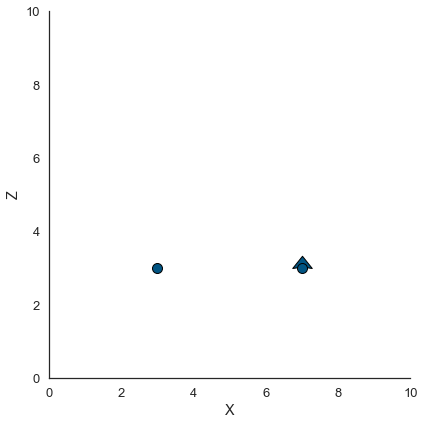

In [6]:
# GemPy has some plot options
gp._plot.plot_data(geo_model)

GemPy is based on [Theano](https://de.wikipedia.org/wiki/Theano_(Deep_Learning)), a library for calculating and optimizing of mathematic expressions (especially multidimensional matrix-calculations). The developers of Theano stopped the project, which was picked up by the PyMC3 developers under the name [aesara](https://github.com/aesara-devs/aesara) and is actively developed under that name.

As GemPy uses a lot of matrix calculations (tensors), an efficient calculation is needed for making modeling feasibly on any hardware. The kriging parameters for the model are set up using `set_interpolator`.

For more information about Theano itself, I reccomend this [Tutorial](https://www.marekrei.com/blog/theano-tutorial/).

In [7]:
# generate Theano Graph

gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                         values
range            14.2828568571
$C_o$             4.8571428571
drift equations         [3, 3]


In [8]:
# Compute the model
sol = gp.compute_model(geo_model, compute_mesh=False)

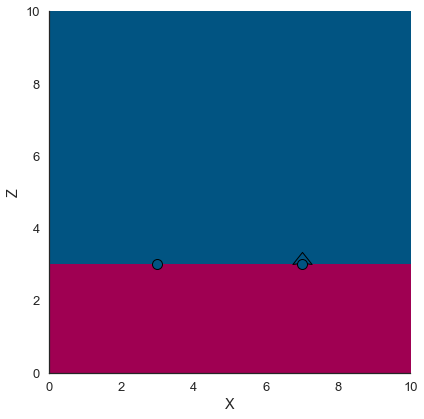

In [9]:
gp._plot.plot_section(geo_model, cell_number=2, direction='y', show_data=True)

<a id='2'></a>
## How do Series work?
### A model with 2 layers and 1 Series
Based on the minimal example, we now add a second set of interface points to show what `Series` are in GemPy. Therefore, we have now two geological layers in our model (exkluding the _basement_):

In [10]:
# Geo-model with 2 layers
geo_model = gp.create_model('2Layer_model')

In [11]:
# initialize data
gp.init_data(geo_model, [0., 10., 0., 2., 0., 10.], [100, 3, 100],
            path_i = 'data/01_2Layer_simple_model_interfaces.csv',
            path_o = 'data/01_2Layer_simple_model_orientation.csv');

Active grids: ['regular']


In [12]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,unit_1,Default series,1,#015482,1
1,unit_2,Default series,2,#9f0052,2
2,basement,Basement,1,#ffbe00,3


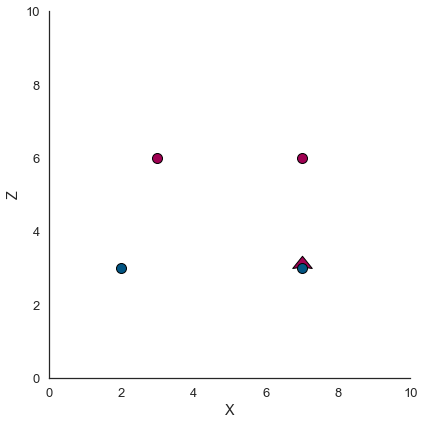

In [13]:
gp._plot.plot_data(geo_model)

In [14]:
# Create the theano model
gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                         values
range            14.2828568571
$C_o$             4.8571428571
drift equations         [3, 3]


In [15]:
# Compute the model
sol = gp.compute_model(geo_model, compute_mesh=False)

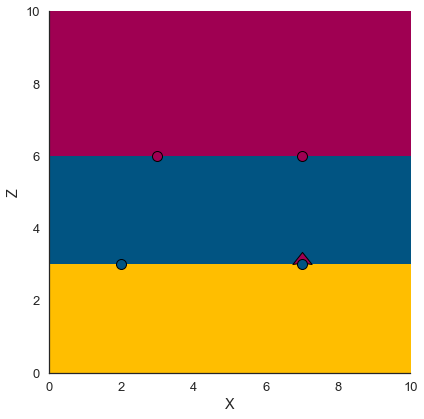

In [16]:
gp._plot.plot_section(geo_model, cell_number=2, direction='y', show_data=True)

This works only, because both layers are in the **same** Series, `default_series`.   
But what happens, if we define 2 series for the 2 units we have?

<a id='2.2'></a>
### A model with 2 layers in 2 Series

In [17]:
gp.map_series_to_surfaces(geo_model,
                         {"Series_1": 'unit_1',
                         "Series_2": 'unit_2'})

,surface,series,order_surfaces,color,id
0,unit_1,Series_1,1,#015482,1
1,unit_2,Series_2,1,#9f0052,2
2,basement,Basement,1,#ffbe00,3


In [18]:
# Create the theano model
gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                         values
range            14.2828568571
$C_o$             4.8571428571
drift equations      [3, 3, 3]


In [19]:
# Compute the model
sol = gp.compute_model(geo_model, compute_mesh=False)
## This will cause an error, and that is on purpose ##

AttributeError: 'CVM' object has no attribute 'maker'
Apply node that caused the error: for{cpu,Looping}(Elemwise{scalar_minimum,no_inplace}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, Number of points per surface used to split rest-ref, fault relation matrix, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, Nugget effect of gradients, Nugget effect of scalar, Attenuation factor, Sigmoid Outside, Sigmoid slope, <TensorType(int32, vector)>, <TensorType(bool, vector)>, <TensorType(int32, vector)>, Coordinates of the grid points to interpolate, All the surface_points points at once, Position of the dips, Angle of every dip, Azimuth, Polarity, Values that the blocks are taking)
Toposort index: 167
Inputs types: [TensorType(int64, scalar), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(bool, vector), TensorType(bool, vector), TensorType(bool, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, 4D), TensorType(float64, matrix), TensorType(float64, 3D), TensorType(float64, 3D), TensorType(bool, 3D), TensorType(bool, 3D), TensorType(float64, 4D), TensorType(int64, vector), TensorType(int32, vector), TensorType(int32, matrix), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(int32, vector), TensorType(bool, vector), TensorType(int32, vector), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, matrix)]
Inputs shapes: [(), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (2, 1, 1, 30002), (2, 7), (2, 1, 30002), (2, 1, 1), (2, 1, 30002), (2, 1, 30002), (2, 1, 1, 30002), (2,), (2,), (1, 1), (), (), (), (3,), (4,), (), (), (), (1,), (1,), (1,), (30000, 3), (4, 3), (1, 3), (1,), (1,), (1,), (1, 1)]
Inputs strides: [(), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (1,), (1,), (1,), (4,), (4,), (4,), (4,), (8,), (8,), (240016, 240016, 240016, 8), (56, 8), (240016, 240016, 8), (8, 8, 8), (30002, 30002, 1), (30002, 30002, 1), (240016, 240016, 240016, 8), (8,), (4,), (4, 4), (), (), (), (8,), (8,), (), (), (), (4,), (1,), (4,), (24, 8), (8, 32), (24, 8), (8,), (8,), (8,), (8, 8)]
Inputs values: [array(1, dtype=int64), array([0]), array([1]), array([0]), array([1]), array([0]), array([7]), array([0]), array([1]), array([3]), array([ True]), array([ True]), array([ True]), array([0]), array([0]), array([0]), array([0]), array([1.42828569]), array([0.48571429]), 'not shown', 'not shown', 'not shown', array([[[0.0e+000]],

       [[3.5e-323]]]), 'not shown', 'not shown', 'not shown', array([0, 7], dtype=int64), array([1, 1]), array([[0]]), array(10.), array(2.), array(4.), array([0.01, 0.01, 0.01]), array([2.e-06, 2.e-06, 2.e-06, 2.e-06]), array(2.), array(50.), array(50000.), array([0]), array([False]), array([0]), 'not shown', 'not shown', array([[0.7501, 0.5001, 0.3501]]), array([0.]), array([90.]), array([1.]), array([[3.]])]
Inputs type_num: [9, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 7, 7, 7, 7, 12, 12, 12, 12, 12, 12, 0, 0, 12, 9, 7, 7, 12, 12, 12, 12, 12, 12, 12, 12, 7, 0, 7, 12, 12, 12, 12, 12, 12, 12]
Outputs clients: [[Subtensor{int64::}(for{cpu,Looping}.0, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.1, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.2, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.3, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.4, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.5, Constant{1})], [], []]

Backtrace when the node is created(use Theano flag traceback__limit=N to make it longer):
  File "C:\Users\Simon\Anaconda3\envs\geoscience_env_py38\lib\site-packages\IPython\core\interactiveshell.py", line 3012, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "C:\Users\Simon\Anaconda3\envs\geoscience_env_py38\lib\site-packages\IPython\core\interactiveshell.py", line 3191, in run_ast_nodes
    if await self.run_code(code, result, async_=asy):
  File "C:\Users\Simon\Anaconda3\envs\geoscience_env_py38\lib\site-packages\IPython\core\interactiveshell.py", line 3251, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Simon\AppData\Local\Temp\ipykernel_17632\1466032538.py", line 2, in <module>
    gp.set_interpolator(geo_model,
  File "C:\Users\Simon\Anaconda3\envs\geoscience_env_py38\lib\site-packages\gempy\api_modules\setters.py", line 108, in set_interpolator
    geo_model._interpolator.compile_th_fn_geo(inplace=True, grid=grid)
  File "C:\Users\Simon\Anaconda3\envs\geoscience_env_py38\lib\site-packages\gempy\core\interpolator.py", line 1124, in compile_th_fn_geo
    self.theano_graph.theano_output(),
  File "C:\Users\Simon\Anaconda3\envs\geoscience_env_py38\lib\site-packages\gempy\core\theano_modules\theano_graph_pro.py", line 631, in theano_output
    solutions[:9] = self.compute_series()
  File "C:\Users\Simon\Anaconda3\envs\geoscience_env_py38\lib\site-packages\gempy\core\theano_modules\theano_graph_pro.py", line 465, in compute_series
    series, self.updates1 = theano.scan(

Debugprint of the apply node: 
for{cpu,Looping}.0 [id A] <TensorType(float64, 4D)> ''   
 |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | |Elemwise{scalar_minimum,no_inplace} [id C] <TensorType(int64, scalar)> ''   
 | | |Elemwise{scalar_minimum,no_inplace} [id D] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{scalar_minimum,no_inplace} [id E] <TensorType(int64, scalar)> ''   
 | | | | |Elemwise{scalar_minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 | | | | | |Elemwise{scalar_minimum,no_inplace} [id G] <TensorType(int64, scalar)> ''   
 | | | | | | |Elemwise{scalar_minimum,no_inplace} [id H] <TensorType(int64, scalar)> ''   
 | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id I] <TensorType(int64, scalar)> ''   
 | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id J] <TensorType(int64, scalar)> ''   
 | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id K] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id L] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id M] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id N] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id O] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id P] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id Q] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | | | |Elemwise{scalar_minimum,no_inplace} [id R] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | | | | |Subtensor{int64} [id S] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | | | | | |Shape [id T] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | | | | | | | |Subtensor{int64:int64:} [id U] <TensorType(int32, vector)> 'Length of surface_points in every series[0:-1]'   
 | | | | | | | | | | | | | | | | | | |Constant{0} [id V] <int64>
 | | | | | | | | | | | | | | | | | |Subtensor{int64} [id W] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | | | |   |Shape [id X] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | | | | |   | |Subtensor{int64::} [id Y] <TensorType(int32, vector)> 'Length of surface_points in every series[1:]'   
 | | | | | | | | | | | | | | | | |   |Constant{0} [id V] <int64>
 | | | | | | | | | | | | | | | | |Subtensor{int64} [id Z] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | | |   |Shape [id BA] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | | | |   | |Subtensor{int64:int64:} [id BB] <TensorType(int32, vector)> 'Length of foliations in every series[0:-1]'   
 | | | | | | | | | | | | | | | |   |Constant{0} [id V] <int64>
 | | | | | | | | | | | | | | | |Subtensor{int64} [id BC] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | |   |Shape [id BD] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | | |   | |Subtensor{int64::} [id BE] <TensorType(int32, vector)> 'Length of foliations in every series[1:]'   
 | | | | | | | | | | | | | | |   |Constant{0} [id V] <int64>
 | | | | | | | | | | | | | | |Subtensor{int64} [id BF] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | |   |Shape [id BG] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | |   | |Subtensor{int64:int64:} [id BH] <TensorType(int32, vector)> 'Length of weights in every series[0:-1]'   
 | | | | | | | | | | | | | |   |Constant{0} [id V] <int64>
 | | | | | | | | | | | | | |Subtensor{int64} [id BI] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | |   |Shape [id BJ] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | |   | |Subtensor{int64::} [id BK] <TensorType(int32, vector)> 'Length of weights in every series[1:]'   
 | | | | | | | | | | | | |   |Constant{0} [id V] <int64>
 | | | | | | | | | | | | |Subtensor{int64} [id BL] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | |   |Shape [id BM] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | |   | |Subtensor{int64:int64:} [id BN] <TensorType(int32, vector)> 'List with the number of surfaces[0:-1]'   
 | | | | | | | | | | | |   |Constant{0} [id V] <int64>
 | | | | | | | | | | | |Subtensor{int64} [id BO] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | |   |Shape [id BP] <TensorType(int64, vector)> ''   
 | | | | | | | | | | |   | |Subtensor{int64::} [id BQ] <TensorType(int32, vector)> 'List with the number of surfaces[1:]'   
 | | | | | | | | | | |   |Constant{0} [id V] <int64>
 | | | | | | | | | | |Subtensor{int64} [id BR] <TensorType(int64, scalar)> ''   
 | | | | | | | | | |   |Shape [id BS] <TensorType(int64, vector)> ''   
 | | | | | | | | | |   | |Subtensor{int64::} [id BT] <TensorType(int32, vector)> 'Grade of the universal drift[0:]'   
 | | | | | | | | | |   |Constant{0} [id V] <int64>
 | | | | | | | | | |Subtensor{int64} [id BU] <TensorType(int64, scalar)> ''   
 | | | | | | | | |   |Shape [id BV] <TensorType(int64, vector)> ''   
 | | | | | | | | |   | |Subtensor{int64::} [id BW] <TensorType(bool, vector)> 'Vector controlling if weights must be recomputed[0:]'   
 | | | | | | | | |   |Constant{0} [id V] <int64>
 | | | | | | | | |Subtensor{int64} [id BX] <TensorType(int64, scalar)> ''   
 | | | | | | | |   |Shape [id BY] <TensorType(int64, vector)> ''   
 | | | | | | | |   | |Subtensor{int64::} [id BZ] <TensorType(bool, vector)> 'Vector controlling if scalar matrix must be recomputed[0:]'   
 | | | | | | | |   |Constant{0} [id V] <int64>
 | | | | | | | |Subtensor{int64} [id CA] <TensorType(int64, scalar)> ''   
 | | | | | | |   |Shape [id CB] <TensorType(int64, vector)> ''   
 | | | | | | |   | |Subtensor{int64::} [id CC] <TensorType(bool, vector)> 'Vector controlling if block matrix must be recomputed[0:]'   
 | | | | | | |   |Constant{0} [id V] <int64>
 | | | | | | |Subtensor{int64} [id CD] <TensorType(int64, scalar)> ''   
 | | | | | |   |Shape [id CE] <TensorType(int64, vector)> ''   
 | | | | | |   | |Subtensor{int64::} [id CF] <TensorType(int32, vector)> 'The series (fault) is finite[0:]'   
 | | | | | |   |Constant{0} [id V] <int64>
 | | | | | |Subtensor{int64} [id CG] <TensorType(int64, scalar)> ''   
 | | | | |   |Shape [id CH] <TensorType(int64, vector)> ''   
 | | | | |   | |Subtensor{int64::} [id CI] <TensorType(int32, vector)> ''   
 | | | | |   |   |<TensorType(int32, vector)> [id CJ] <TensorType(int32, vector)>
 | | | | |   |   |Constant{0} [id V] <int64>
 | | | | |   |Constant{0} [id V] <int64>
 | | | | |Subtensor{int64} [id CK] <TensorType(int64, scalar)> ''   
 | | | |   |Shape [id CL] <TensorType(int64, vector)> ''   
 | | | |   | |Subtensor{int64::} [id CM] <TensorType(int32, vector)> ''   
 | | | |   |   |<TensorType(int32, vector)> [id CN] <TensorType(int32, vector)>
 | | | |   |   |Constant{0} [id V] <int64>
 | | | |   |Constant{0} [id V] <int64>
 | | | |TensorConstant{5000} [id CO] <TensorType(int64, scalar)>
 | | |Subtensor{int64} [id CP] <TensorType(int64, scalar)> ''   
 | |   |Shape [id CQ] <TensorType(int64, vector)> ''   
 | |   | |Subtensor{int64::} [id CR] <TensorType(float64, vector)> 'Range[0:]'   
 | |   |Constant{0} [id V] <int64>
 | |Subtensor{int64} [id CS] <TensorType(int64, scalar)> ''   
 |   |Shape [id CT] <TensorType(int64, vector)> ''   
 |   | |Subtensor{int64::} [id CU] <TensorType(float64, vector)> 'Covariance at 0[0:]'   
 |   |Constant{0} [id V] <int64>
 |Subtensor{:int64:} [id CV] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id U] <TensorType(int32, vector)> 'Length of surface_points in every series[0:-1]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 |Subtensor{:int64:} [id CX] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id Y] <TensorType(int32, vector)> 'Length of surface_points in every series[1:]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id CY] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id BB] <TensorType(int32, vector)> 'Length of foliations in every series[0:-1]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id CZ] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BE] <TensorType(int32, vector)> 'Length of foliations in every series[1:]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DA] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id BH] <TensorType(int32, vector)> 'Length of weights in every series[0:-1]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DB] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BK] <TensorType(int32, vector)> 'Length of weights in every series[1:]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DC] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id BN] <TensorType(int32, vector)> 'List with the number of surfaces[0:-1]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DD] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BQ] <TensorType(int32, vector)> 'List with the number of surfaces[1:]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DE] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BT] <TensorType(int32, vector)> 'Grade of the universal drift[0:]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DF] <TensorType(bool, vector)> ''   
 | |Subtensor{int64::} [id BW] <TensorType(bool, vector)> 'Vector controlling if weights must be recomputed[0:]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DG] <TensorType(bool, vector)> ''   
 | |Subtensor{int64::} [id BZ] <TensorType(bool, vector)> 'Vector controlling if scalar matrix must be recomputed[0:]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DH] <TensorType(bool, vector)> ''   
 | |Subtensor{int64::} [id CC] <TensorType(bool, vector)> 'Vector controlling if block matrix must be recomputed[0:]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DI] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id CF] <TensorType(int32, vector)> 'The series (fault) is finite[0:]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DJ] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id CI] <TensorType(int32, vector)> ''   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DK] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id CM] <TensorType(int32, vector)> ''   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DL] <TensorType(int32, vector)> ''   
 | |TensorConstant{[   0    1..4998 4999]} [id DM] <TensorType(int32, vector)>
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DN] <TensorType(float64, vector)> ''   
 | |Subtensor{int64::} [id CR] <TensorType(float64, vector)> 'Range[0:]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |Subtensor{:int64:} [id DO] <TensorType(float64, vector)> ''   
 | |Subtensor{int64::} [id CU] <TensorType(float64, vector)> 'Covariance at 0[0:]'   
 | |ScalarFromTensor [id CW] <int64> ''   
 |IncSubtensor{Set;:int64:} [id DP] <TensorType(float64, 4D)> ''   
 | |AllocEmpty{dtype='float64'} [id DQ] <TensorType(float64, 4D)> ''   
 | | |Elemwise{add,no_inplace} [id DR] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id DS] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id DT] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id DU] <TensorType(float64, 4D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1,2} [id DV] <TensorType(float64, (True, False, False, False))> ''   
 | | |   |     |block matrix [id DW] <TensorType(float64, 3D)>
 | | |   |Constant{0} [id V] <int64>
 | | |Subtensor{int64} [id DX] <TensorType(int64, scalar)> ''   
 | | | |Shape [id DT] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DY] <int64>
 | | |Subtensor{int64} [id DZ] <TensorType(int64, scalar)> ''   
 | | | |Shape [id DT] <TensorType(int64, vector)> ''   
 | | | |Constant{2} [id EA] <int64>
 | | |Subtensor{int64} [id EB] <TensorType(int64, scalar)> ''   
 | |   |Shape [id DT] <TensorType(int64, vector)> ''   
 | |   |Constant{3} [id EC] <int64>
 | |Rebroadcast{0} [id DU] <TensorType(float64, 4D)> ''   
 | |ScalarFromTensor [id ED] <int64> ''   
 |   |Subtensor{int64} [id DS] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id EE] <TensorType(float64, matrix)> ''   
 | |AllocEmpty{dtype='float64'} [id EF] <TensorType(float64, matrix)> ''   
 | | |Elemwise{add,no_inplace} [id EG] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id EH] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id EI] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id EJ] <TensorType(float64, matrix)> ''   
 | | |   |   |InplaceDimShuffle{x,0} [id EK] <TensorType(float64, row)> ''   
 | | |   |     |Weights vector [id EL] <TensorType(float64, vector)>
 | | |   |Constant{0} [id V] <int64>
 | | |Subtensor{int64} [id EM] <TensorType(int64, scalar)> ''   
 | |   |Shape [id EI] <TensorType(int64, vector)> ''   
 | |   |Constant{1} [id DY] <int64>
 | |Rebroadcast{0} [id EJ] <TensorType(float64, matrix)> ''   
 | |ScalarFromTensor [id EN] <int64> ''   
 |   |Subtensor{int64} [id EH] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id EO] <TensorType(float64, 3D)> ''   
 | |AllocEmpty{dtype='float64'} [id EP] <TensorType(float64, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id EQ] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id ER] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id ES] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id ET] <TensorType(float64, 3D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1} [id EU] <TensorType(float64, (True, False, False))> ''   
 | | |   |     |Scalar matrix [id EV] <TensorType(float64, matrix)>
 | | |   |Constant{0} [id V] <int64>
 | | |Subtensor{int64} [id EW] <TensorType(int64, scalar)> ''   
 | | | |Shape [id ES] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DY] <int64>
 | | |Subtensor{int64} [id EX] <TensorType(int64, scalar)> ''   
 | |   |Shape [id ES] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id EA] <int64>
 | |Rebroadcast{0} [id ET] <TensorType(float64, 3D)> ''   
 | |ScalarFromTensor [id EY] <int64> ''   
 |   |Subtensor{int64} [id ER] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id EZ] <TensorType(float64, 3D)> ''   
 | |AllocEmpty{dtype='float64'} [id FA] <TensorType(float64, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id FB] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id FC] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id FD] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id FE] <TensorType(float64, 3D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1} [id FF] <TensorType(float64, (True, False, False))> ''   
 | | |   |     |Alloc [id FG] <TensorType(float64, matrix)> ''   
 | | |   |       |TensorConstant{0.0} [id FH] <TensorType(float64, scalar)>
 | | |   |       |Subtensor{int64} [id FI] <TensorType(int64, scalar)> ''   
 | | |   |       | |Shape [id FJ] <TensorType(int64, vector)> ''   
 | | |   |       | | |<TensorType(int32, vector)> [id CJ] <TensorType(int32, vector)>
 | | |   |       | |Constant{0} [id V] <int64>
 | | |   |       |Subtensor{int64} [id FK] <TensorType(int32, scalar)> ''   
 | | |   |         |List with the number of surfaces [id FL] <TensorType(int32, vector)>
 | | |   |         |Constant{-1} [id FM] <int64>
 | | |   |Constant{0} [id V] <int64>
 | | |Subtensor{int64} [id FN] <TensorType(int64, scalar)> ''   
 | | | |Shape [id FD] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DY] <int64>
 | | |Subtensor{int64} [id FO] <TensorType(int64, scalar)> ''   
 | |   |Shape [id FD] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id EA] <int64>
 | |Rebroadcast{0} [id FE] <TensorType(float64, 3D)> ''   
 | |ScalarFromTensor [id FP] <int64> ''   
 |   |Subtensor{int64} [id FC] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id FQ] <TensorType(bool, 3D)> ''   
 | |AllocEmpty{dtype='bool'} [id FR] <TensorType(bool, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id FS] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id FT] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id FU] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id FV] <TensorType(bool, 3D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1} [id FW] <TensorType(bool, (True, False, False))> ''   
 | | |   |     |mask matrix [id FX] <TensorType(bool, matrix)>
 | | |   |Constant{0} [id V] <int64>
 | | |Subtensor{int64} [id FY] <TensorType(int64, scalar)> ''   
 | | | |Shape [id FU] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DY] <int64>
 | | |Subtensor{int64} [id FZ] <TensorType(int64, scalar)> ''   
 | |   |Shape [id FU] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id EA] <int64>
 | |Rebroadcast{0} [id FV] <TensorType(bool, 3D)> ''   
 | |ScalarFromTensor [id GA] <int64> ''   
 |   |Subtensor{int64} [id FT] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id GB] <TensorType(bool, 3D)> ''   
 | |AllocEmpty{dtype='bool'} [id GC] <TensorType(bool, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id GD] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id GE] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id GF] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id GG] <TensorType(bool, 3D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1} [id GH] <TensorType(bool, (True, False, False))> ''   
 | | |   |     |Elemwise{second,no_inplace} [id GI] <TensorType(bool, matrix)> ''   
 | | |   |       |mask matrix [id FX] <TensorType(bool, matrix)>
 | | |   |       |TensorConstant{(1, 1) of False} [id GJ] <TensorType(bool, (True, True))>
 | | |   |Constant{0} [id V] <int64>
 | | |Subtensor{int64} [id GK] <TensorType(int64, scalar)> ''   
 | | | |Shape [id GF] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DY] <int64>
 | | |Subtensor{int64} [id GL] <TensorType(int64, scalar)> ''   
 | |   |Shape [id GF] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id EA] <int64>
 | |Rebroadcast{0} [id GG] <TensorType(bool, 3D)> ''   
 | |ScalarFromTensor [id GM] <int64> ''   
 |   |Subtensor{int64} [id GE] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id GN] <TensorType(float64, 4D)> ''   
 | |AllocEmpty{dtype='float64'} [id GO] <TensorType(float64, 4D)> ''   
 | | |Elemwise{add,no_inplace} [id GP] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id GQ] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id GR] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id GS] <TensorType(float64, 4D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1,2} [id GT] <TensorType(float64, (True, False, False, False))> ''   
 | | |   |     |Elemwise{second,no_inplace} [id GU] <TensorType(float64, 3D)> ''   
 | | |   |       |block matrix [id DW] <TensorType(float64, 3D)>
 | | |   |       |TensorConstant{(1, 1, 1) of 0.0} [id GV] <TensorType(float64, (True, True, True))>
 | | |   |Constant{0} [id V] <int64>
 | | |Subtensor{int64} [id GW] <TensorType(int64, scalar)> ''   
 | | | |Shape [id GR] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DY] <int64>
 | | |Subtensor{int64} [id GX] <TensorType(int64, scalar)> ''   
 | | | |Shape [id GR] <TensorType(int64, vector)> ''   
 | | | |Constant{2} [id EA] <int64>
 | | |Subtensor{int64} [id GY] <TensorType(int64, scalar)> ''   
 | |   |Shape [id GR] <TensorType(int64, vector)> ''   
 | |   |Constant{3} [id EC] <int64>
 | |Rebroadcast{0} [id GS] <TensorType(float64, 4D)> ''   
 | |ScalarFromTensor [id GZ] <int64> ''   
 |   |Subtensor{int64} [id GQ] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id HA] <TensorType(int64, vector)> ''   
 | |AllocEmpty{dtype='int64'} [id HB] <TensorType(int64, vector)> ''   
 | | |Elemwise{add,no_inplace} [id HC] <TensorType(int64, scalar)> ''   
 | |   |Elemwise{scalar_minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | |   |TensorConstant{1} [id HD] <TensorType(int64, scalar)>
 | |TensorConstant{(1,) of 0} [id HE] <TensorType(int64, vector)>
 | |Constant{1} [id DY] <int64>
 |Number of points per surface used to split rest-ref [id HF] <TensorType(int32, vector)>
 |fault relation matrix [id HG] <TensorType(int32, matrix)>
 |<TensorType(float64, scalar)> [id HH] <TensorType(float64, scalar)>
 |<TensorType(float64, scalar)> [id HI] <TensorType(float64, scalar)>
 |<TensorType(float64, scalar)> [id HJ] <TensorType(float64, scalar)>
 |Nugget effect of gradients [id HK] <TensorType(float64, vector)>
 |Nugget effect of scalar [id HL] <TensorType(float64, vector)>
 |Attenuation factor [id HM] <TensorType(float64, scalar)>
 |Sigmoid Outside [id HN] <TensorType(float64, scalar)>
 |Sigmoid slope [id HO] <TensorType(float64, scalar)>
 |<TensorType(int32, vector)> [id CN] <TensorType(int32, vector)>
 |<TensorType(bool, vector)> [id HP] <TensorType(bool, vector)>
 |<TensorType(int32, vector)> [id CJ] <TensorType(int32, vector)>
 |Coordinates of the grid points to interpolate [id HQ] <TensorType(float64, matrix)>
 |All the surface_points points at once [id HR] <TensorType(float64, matrix)>
 |Position of the dips [id HS] <TensorType(float64, matrix)>
 |Angle of every dip [id HT] <TensorType(float64, vector)>
 |Azimuth [id HU] <TensorType(float64, vector)>
 |Polarity [id HV] <TensorType(float64, vector)>
 |Values that the blocks are taking [id HW] <TensorType(float64, matrix)>
for{cpu,Looping}.1 [id A] <TensorType(float64, matrix)> ''   
for{cpu,Looping}.2 [id A] <TensorType(float64, 3D)> ''   
for{cpu,Looping}.3 [id A] <TensorType(float64, 3D)> ''   
for{cpu,Looping}.4 [id A] <TensorType(bool, 3D)> ''   
for{cpu,Looping}.5 [id A] <TensorType(bool, 3D)> ''   
for{cpu,Looping}.6 [id A] <TensorType(float64, 4D)> ''   
for{cpu,Looping}.7 [id A] <TensorType(int64, vector)> ''   

Inner graphs of the scan ops:

for{cpu,Looping}.0 [id A] <TensorType(float64, 4D)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HX] <TensorType(float64, 3D)> ''   
 > |block matrix[t-1] [id HY] <TensorType(float64, 3D)> -> [id DP]
 > |if{{{','.join(args)}}} [id HZ] <TensorType(float64, matrix)> ''   
 > | |Vector controlling if block matrix must be recomputed[t] [id IA] <TensorType(bool, scalar)> -> [id DH]
 > | |if{{{','.join(args)}}} [id IB] <TensorType(float64, matrix)> ''   
 > | | |The series (fault) is finite[t] [id IC] <TensorType(int32, scalar)> -> [id DI]
 > | | |Sum{axis=[0], acc_dtype=float64} [id ID] <TensorType(float64, matrix)> 'The chunk of block model of a specific series'   
 > | | |Sum{axis=[0], acc_dtype=float64} [id IE] <TensorType(float64, matrix)> 'The chunk of block model of a specific series'   
 > | |Subtensor{int32, ::} [id IF] <TensorType(float64, matrix)> ''   
 > |   |block matrix[t-1] [id HY] <TensorType(float64, 3D)> -> [id DP]
 > |   |ScalarFromTensor [id IG] <int32> ''   
 > |     |<TensorType(int32, scalar)> [id IH] <TensorType(int32, scalar)> -> [id DL]
 > |ScalarFromTensor [id IG] <int32> ''   
 > |Constant{0} [id II] <int8>
 > |ScalarFromTensor [id IJ] <int64> ''   
 >   |Elemwise{add,no_inplace} [id IK] <TensorType(int64, scalar)> ''   
 >     |Elemwise{add,no_inplace} [id IL] <TensorType(int64, scalar)> ''   
 >     | |Subtensor{int64} [id IM] <TensorType(int64, scalar)> ''   
 >     | | |Shape [id IN] <TensorType(int64, vector)> ''   
 >     | | | |Coordinates of the grid points to interpolate_copy [id IO] <TensorType(float64, matrix)> -> [id HQ]
 >     | | |Constant{0} [id IP] <int64>
 >     | |Elemwise{mul,no_inplace} [id IQ] <TensorType(int64, scalar)> ''   
 >     |   |TensorConstant{2} [id IR] <TensorType(int8, scalar)>
 >     |   |Elemwise{sub,no_inplace} [id IS] <TensorType(int64, scalar)> ''   
 >     |     |Subtensor{int64} [id IT] <TensorType(int64, scalar)> ''   
 >     |     | |Shape [id IU] <TensorType(int64, vector)> ''   
 >     |     | | |All the surface_points points at once_copy [id IV] <TensorType(float64, matrix)> -> [id HR]
 >     |     | |Constant{0} [id IP] <int64>
 >     |     |Subtensor{int64} [id IW] <TensorType(int64, scalar)> ''   
 >     |       |Shape [id IX] <TensorType(int64, vector)> ''   
 >     |       | |Number of points per surface used to split rest-ref_copy [id IY] <TensorType(int32, vector)> -> [id HF]
 >     |       |Constant{0} [id IP] <int64>
 >     |TensorConstant{0} [id IZ] <TensorType(int8, scalar)>
 >IncSubtensor{Set;int32:int32:} [id JA] <TensorType(float64, vector)> ''   
 > |Weights vector[t-1] [id JB] <TensorType(float64, vector)> -> [id EE]
 > |if{{{','.join(args)}}} [id JC] <TensorType(float64, vector)> ''   
 > | |Vector controlling if weights must be recomputed[t] [id JD] <TensorType(bool, scalar)> -> [id DF]
 > | |Reshape{1} [id JE] <TensorType(float64, vector)> 'Dual Kriging parameters'   
 > | |Subtensor{int32:int32:} [id JF] <TensorType(float64, vector)> ''   
 > |   |Weights vector[t-1] [id JB] <TensorType(float64, vector)> -> [id EE]
 > |   |ScalarFromTensor [id JG] <int32> ''   
 > |   | |Length of weights in every series[t] [id JH] <TensorType(int32, scalar)> -> [id DA]
 > |   |ScalarFromTensor [id JI] <int32> ''   
 > |     |Length of weights in every series[t+1] [id JJ] <TensorType(int32, scalar)> -> [id DB]
 > |ScalarFromTensor [id JG] <int32> ''   
 > |ScalarFromTensor [id JI] <int32> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JK] <TensorType(float64, matrix)> ''   
 > |Scalar matrix[t-1] [id JL] <TensorType(float64, matrix)> -> [id EO]
 > |if{{{','.join(args)}}} [id JM] <TensorType(float64, vector)> ''   
 > | |Vector controlling if scalar matrix must be recomputed[t] [id JN] <TensorType(bool, scalar)> -> [id DG]
 > | |Subtensor{int64} [id JO] <TensorType(float64, vector)> 'Value of the potential field at every point'   
 > | |Subtensor{int32} [id JP] <TensorType(float64, vector)> ''   
 > |   |Scalar matrix[t-1] [id JL] <TensorType(float64, matrix)> -> [id EO]
 > |   |ScalarFromTensor [id IG] <int32> ''   
 > |ScalarFromTensor [id IG] <int32> ''   
 > |Constant{0} [id II] <int8>
 > |ScalarFromTensor [id IJ] <int64> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JQ] <TensorType(float64, matrix)> ''   
 > |<TensorType(float64, matrix)> [id JR] <TensorType(float64, matrix)> -> [id EZ]
 > |AdvancedSubtensor1 [id JS] <TensorType(float64, vector)> ''   
 > | |Subtensor{int64:int64:} [id JT] <TensorType(float64, vector)> ''   
 > | | |if{{{','.join(args)}}} [id JM] <TensorType(float64, vector)> ''   
 > | | |ScalarFromTensor [id JU] <int64> ''   
 > | | | |Elemwise{mul,no_inplace} [id JV] <TensorType(int64, scalar)> ''   
 > | | |   |TensorConstant{-2} [id JW] <TensorType(int8, scalar)>
 > | | |   |Elemwise{sub,no_inplace} [id IS] <TensorType(int64, scalar)> ''   
 > | | |ScalarFromTensor [id JX] <int64> ''   
 > | |   |Elemwise{neg,no_inplace} [id JY] <TensorType(int64, scalar)> ''   
 > | |     |Elemwise{sub,no_inplace} [id IS] <TensorType(int64, scalar)> ''   
 > | |Subtensor{int32:int32:} [id JZ] <TensorType(int32, vector)> ''   
 > |   |CumOp{None, add} [id KA] <TensorType(int32, vector)> 'Number of points per surfaces after rest-ref. This is used for finding the differentsurface points withing a layer.'   
 > |   |ScalarFromTensor [id KB] <int32> ''   
 > |   | |List with the number of surfaces[t] [id KC] <TensorType(int32, scalar)> -> [id DC]
 > |   |ScalarFromTensor [id KD] <int32> ''   
 > |     |List with the number of surfaces[t+1] [id KE] <TensorType(int32, scalar)> -> [id DD]
 > |<TensorType(int32, scalar)> [id IH] <TensorType(int32, scalar)> -> [id DL]
 > |Elemwise{sub,no_inplace} [id KF] <TensorType(int32, vector)> ''   
 >   |Subtensor{int32:int32:} [id KG] <TensorType(int32, vector)> ''   
 >   | |TensorConstant{[   1    2..4998 4999]} [id KH] <TensorType(int32, vector)>
 >   | |ScalarFromTensor [id KB] <int32> ''   
 >   | |ScalarFromTensor [id KD] <int32> ''   
 >   |TensorConstant{(1,) of 1} [id KI] <TensorType(int8, (True,))>
 >IncSubtensor{Set;int32, int8:int64:} [id KJ] <TensorType(bool, matrix)> ''   
 > |IncSubtensor{Set;int64:int32:, int8:int64:} [id KK] <TensorType(bool, matrix)> ''   
 > | |IncSubtensor{Set;int32:int32:, int8:int64:} [id KL] <TensorType(bool, matrix)> ''   
 > | | |mask matrix[t-1] [id KM] <TensorType(bool, matrix)> -> [id FQ]
 > | | |if{{{','.join(args)}}} [id KN] <TensorType(bool, vector)> ''   
 > | | | |<TensorType(int32, scalar)> [id KO] <TensorType(int32, scalar)> -> [id DK]
 > | | | |Elemwise{gt,no_inplace} [id KP] <TensorType(bool, vector)> ''   
 > | | | | |if{{{','.join(args)}}} [id JM] <TensorType(float64, vector)> ''   
 > | | | | |InplaceDimShuffle{x} [id KQ] <TensorType(float64, (True,))> ''   
 > | | | |   |MaxAndArgmax{axis=(0,)}.0 [id KR] <TensorType(float64, scalar)> 'max'   
 > | | | |Subtensor{int32, int8:int64:} [id KS] <TensorType(bool, vector)> ''   
 > | | |   |mask matrix[t-1] [id KM] <TensorType(bool, matrix)> -> [id FQ]
 > | | |   |ScalarFromTensor [id KT] <int32> ''   
 > | | |   | |Elemwise{sub,no_inplace} [id KU] <TensorType(int32, scalar)> ''   
 > | | |   |   |<TensorType(int32, scalar)> [id IH] <TensorType(int32, scalar)> -> [id DL]
 > | | |   |   |TensorConstant{1} [id KV] <TensorType(int8, scalar)>
 > | | |   |Constant{0} [id II] <int8>
 > | | |   |ScalarFromTensor [id IJ] <int64> ''   
 > | | |ScalarFromTensor [id KT] <int32> ''   
 > | | |ScalarFromTensor [id IG] <int32> ''   
 > | | |Constant{0} [id II] <int8>
 > | | |ScalarFromTensor [id IJ] <int64> ''   
 > | |Subtensor{::int64} [id KW] <TensorType(bool, matrix)> ''   
 > | | |CumOp{0, mul} [id KX] <TensorType(bool, matrix)> ''   
 > | | | |Subtensor{::int64} [id KY] <TensorType(bool, matrix)> ''   
 > | | |   |Subtensor{int64:int32:, int8:int64:} [id KZ] <TensorType(bool, matrix)> ''   
 > | | |   | |IncSubtensor{Set;int32:int32:, int8:int64:} [id KL] <TensorType(bool, matrix)> ''   
 > | | |   | |ScalarFromTensor [id LA] <int64> ''   
 > | | |   | | |Elemwise{sub,no_inplace} [id LB] <TensorType(int64, scalar)> ''   
 > | | |   | |   |<TensorType(int32, scalar)> [id IH] <TensorType(int32, scalar)> -> [id DL]
 > | | |   | |   |Elemwise{mul,no_inplace} [id LC] <TensorType(int64, scalar)> ''   
 > | | |   | |     |Elemwise{mul,no_inplace} [id LD] <TensorType(int64, scalar)> ''   
 > | | |   | |     | |Elemwise{add,no_inplace} [id LE] <TensorType(int64, scalar)> ''   
 > | | |   | |     | | |<TensorType(int64, scalar)> [id LF] <TensorType(int64, scalar)> -> [id HA]
 > | | |   | |     | | |Elemwise{add,no_inplace} [id LG] <TensorType(int32, scalar)> ''   
 > | | |   | |     | |   |Subtensor{int32} [id LH] <TensorType(int32, scalar)> ''   
 > | | |   | |     | |   | |<TensorType(int32, vector)> [id LI] <TensorType(int32, vector)> -> [id CN]
 > | | |   | |     | |   | |ScalarFromTensor [id IG] <int32> ''   
 > | | |   | |     | |   |Subtensor{int32} [id LJ] <TensorType(bool, scalar)> ''   
 > | | |   | |     | |     |<TensorType(bool, vector)> [id LK] <TensorType(bool, vector)> -> [id HP]
 > | | |   | |     | |     |ScalarFromTensor [id IG] <int32> ''   
 > | | |   | |     | |Elemwise{add,no_inplace} [id LG] <TensorType(int32, scalar)> ''   
 > | | |   | |     |Subtensor{int64} [id LL] <TensorType(int32, scalar)> ''   
 > | | |   | |       |<TensorType(int32, vector)> [id LI] <TensorType(int32, vector)> -> [id CN]
 > | | |   | |       |ScalarFromTensor [id LM] <int64> ''   
 > | | |   | |         |Elemwise{sub,no_inplace} [id LN] <TensorType(int64, scalar)> ''   
 > | | |   | |           |<TensorType(int32, scalar)> [id IH] <TensorType(int32, scalar)> -> [id DL]
 > | | |   | |           |<TensorType(int64, scalar)> [id LF] <TensorType(int64, scalar)> -> [id HA]
 > | | |   | |ScalarFromTensor [id IG] <int32> ''   
 > | | |   | |Constant{0} [id II] <int8>
 > | | |   | |ScalarFromTensor [id IJ] <int64> ''   
 > | | |   |Constant{-1} [id LO] <int64>
 > | | |Constant{-1} [id LO] <int64>
 > | |ScalarFromTensor [id LA] <int64> ''   
 > | |ScalarFromTensor [id IG] <int32> ''   
 > | |Constant{0} [id II] <int8>
 > | |ScalarFromTensor [id IJ] <int64> ''   
 > |if{{{','.join(args)}}} [id LP] <TensorType(bool, vector)> ''   
 > | |<TensorType(int32, scalar)> [id LQ] <TensorType(int32, scalar)> -> [id DJ]
 > | |Elemwise{gt,no_inplace} [id LR] <TensorType(bool, vector)> ''   
 > | | |if{{{','.join(args)}}} [id JM] <TensorType(float64, vector)> ''   
 > | | |InplaceDimShuffle{x} [id LS] <TensorType(float64, (True,))> ''   
 > | |   |Elemwise{neg,no_inplace} [id LT] <TensorType(float64, scalar)> ''   
 > | |     |MaxAndArgmax{axis=(0,)}.0 [id LU] <TensorType(float64, scalar)> 'max'   
 > | |Elemwise{mul,no_inplace} [id LV] <TensorType(bool, vector)> ''   
 > |   |InplaceDimShuffle{x} [id LW] <TensorType(bool, (True,))> ''   
 > |   | |Elemwise{invert,no_inplace} [id LX] <TensorType(bool, scalar)> ''   
 > |   |   |Subtensor{int32} [id LJ] <TensorType(bool, scalar)> ''   
 > |   |Elemwise{second,no_inplace} [id LY] <TensorType(bool, vector)> ''   
 > |     |if{{{','.join(args)}}} [id JM] <TensorType(float64, vector)> ''   
 > |     |TensorConstant{(1,) of True} [id LZ] <TensorType(bool, (True,))>
 > |ScalarFromTensor [id IG] <int32> ''   
 > |Constant{0} [id II] <int8>
 > |ScalarFromTensor [id IJ] <int64> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id MA] <TensorType(bool, matrix)> ''   
 > |<TensorType(bool, matrix)> [id MB] <TensorType(bool, matrix)> -> [id GB]
 > |Elemwise{add,no_inplace} [id MC] <TensorType(bool, vector)> ''   
 > | |if{{{','.join(args)}}} [id LP] <TensorType(bool, vector)> ''   
 > | |if{{{','.join(args)}}} [id MD] <TensorType(bool, vector)> ''   
 > |   |Subtensor{int32} [id LJ] <TensorType(bool, scalar)> ''   
 > |   |Elemwise{gt,no_inplace} [id LR] <TensorType(bool, vector)> ''   
 > |   |Elemwise{second,no_inplace} [id ME] <TensorType(bool, vector)> ''   
 > |     |if{{{','.join(args)}}} [id JM] <TensorType(float64, vector)> ''   
 > |     |TensorConstant{(1,) of False} [id MF] <TensorType(bool, (True,))>
 > |Elemwise{mul,no_inplace} [id MG] <TensorType(bool, vector)> ''   
 > | |Subtensor{:int64:} [id MH] <TensorType(bool, vector)> ''   
 > | | |<TensorType(bool, vector)> [id LK] <TensorType(bool, vector)> -> [id HP]
 > | | |ScalarFromTensor [id MI] <int64> ''   
 > | |   |Subtensor{int64} [id MJ] <TensorType(int64, scalar)> ''   
 > | |     |Shape [id MK] <TensorType(int64, vector)> ''   
 > | |     | |<TensorType(int32, vector)> [id ML] <TensorType(int32, vector)> -> [id CJ]
 > | |     |Constant{0} [id IP] <int64>
 > | |Elemwise{invert,no_inplace} [id MM] <TensorType(bool, vector)> ''   
 > |   |Elemwise{Cast{bool}} [id MN] <TensorType(bool, vector)> ''   
 > |     |Subtensor{:int64:} [id MO] <TensorType(int32, vector)> ''   
 > |       |Subtensor{::, int8} [id MP] <TensorType(int32, vector)> ''   
 > |       | |fault relation matrix_copy [id MQ] <TensorType(int32, matrix)> -> [id HG]
 > |       | |ScalarFromTensor [id MR] <int8> ''   
 > |       |   |Elemwise{Cast{int8}} [id MS] <TensorType(int8, scalar)> ''   
 > |       |     |<TensorType(int32, scalar)> [id IH] <TensorType(int32, scalar)> -> [id DL]
 > |       |ScalarFromTensor [id MI] <int64> ''   
 > |MakeSlice [id MT] <slice> ''   
 >   |TensorConstant{0} [id IZ] <TensorType(int8, scalar)>
 >   |Elemwise{add,no_inplace} [id IK] <TensorType(int64, scalar)> ''   
 >   |NoneConst [id MU] <NoneTypeT>
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MV] <TensorType(float64, 3D)> ''   
 > |<TensorType(float64, 3D)> [id MW] <TensorType(float64, 3D)> -> [id GN]
 > |if{{{','.join(args)}}} [id HZ] <TensorType(float64, matrix)> ''   
 > |ScalarFromTensor [id IG] <int32> ''   
 > |Constant{0} [id II] <int8>
 > |ScalarFromTensor [id IJ] <int64> ''   
 >Elemwise{mul,no_inplace} [id LC] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.1 [id A] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HX] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id JA] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JK] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JQ] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KJ] <TensorType(bool, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id MA] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MV] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id LC] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.2 [id A] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HX] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id JA] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JK] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JQ] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KJ] <TensorType(bool, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id MA] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MV] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id LC] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.3 [id A] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HX] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id JA] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JK] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JQ] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KJ] <TensorType(bool, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id MA] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MV] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id LC] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.4 [id A] <TensorType(bool, 3D)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HX] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id JA] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JK] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JQ] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KJ] <TensorType(bool, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id MA] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MV] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id LC] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.5 [id A] <TensorType(bool, 3D)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HX] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id JA] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JK] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JQ] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KJ] <TensorType(bool, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id MA] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MV] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id LC] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.6 [id A] <TensorType(float64, 4D)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HX] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id JA] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JK] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JQ] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KJ] <TensorType(bool, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id MA] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MV] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id LC] <TensorType(int64, scalar)> ''   

for{cpu,Looping}.7 [id A] <TensorType(int64, vector)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id HX] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id JA] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id JK] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id JQ] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, int8:int64:} [id KJ] <TensorType(bool, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id MA] <TensorType(bool, matrix)> ''   
 >IncSubtensor{Set;int32, ::, int8:int64:} [id MV] <TensorType(float64, 3D)> ''   
 >Elemwise{mul,no_inplace} [id LC] <TensorType(int64, scalar)> ''   

Storage map footprint:
 - Coordinates of the grid points to interpolate, Input, Shape: (30000, 3), ElemSize: 8 Byte(s), TotalSize: 720000 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 1, 1, 30002), ElemSize: 8 Byte(s), TotalSize: 480032 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 1, 30002), ElemSize: 8 Byte(s), TotalSize: 480032 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 1, 1, 30002), ElemSize: 8 Byte(s), TotalSize: 480032 Byte(s)
 - for{cpu,Looping}.0, Shape: (2, 1, 1, 30002), ElemSize: 8 Byte(s), TotalSize: 480032 Byte(s)
 - for{cpu,Looping}.2, Shape: (2, 1, 30002), ElemSize: 8 Byte(s), TotalSize: 480032 Byte(s)
 - for{cpu,Looping}.6, Shape: (2, 1, 1, 30002), ElemSize: 8 Byte(s), TotalSize: 480032 Byte(s)
 - block matrix, Shared Input, Shape: (1, 1, 30002), ElemSize: 8 Byte(s), TotalSize: 240016 Byte(s)
 - Scalar matrix, Shared Input, Shape: (1, 30002), ElemSize: 8 Byte(s), TotalSize: 240016 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 1, 30002), ElemSize: 1 Byte(s), TotalSize: 60004 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 1, 30002), ElemSize: 1 Byte(s), TotalSize: 60004 Byte(s)
 - for{cpu,Looping}.4, Shape: (2, 1, 30002), ElemSize: 1 Byte(s), TotalSize: 60004 Byte(s)
 - for{cpu,Looping}.5, Shape: (2, 1, 30002), ElemSize: 1 Byte(s), TotalSize: 60004 Byte(s)
 - mask matrix, Shared Input, Shape: (1, 30002), ElemSize: 1 Byte(s), TotalSize: 30002 Byte(s)
 - TensorConstant{[   0    1..4998 4999]}, Shape: (5000,), ElemSize: 4 Byte(s), TotalSize: 20000 Byte(s)
 - Vector controlling if weights must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - Vector controlling if scalar matrix must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - Vector controlling if block matrix must be recomputed, Input, Shape: (1000,), ElemSize: 1 Byte(s), TotalSize: 1000 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 7), ElemSize: 8 Byte(s), TotalSize: 112 Byte(s)
 - for{cpu,Looping}.1, Shape: (2, 7), ElemSize: 8 Byte(s), TotalSize: 112 Byte(s)
 - All the surface_points points at once, Input, Shape: (4, 3), ElemSize: 8 Byte(s), TotalSize: 96 Byte(s)
 - Weights vector, Shared Input, Shape: (7,), ElemSize: 8 Byte(s), TotalSize: 56 Byte(s)
 - Nugget effect of scalar, Shared Input, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Position of the dips, Input, Shape: (1, 3), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - Range, Shared Input, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - Covariance at 0, Shared Input, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - Nugget effect of gradients, Shared Input, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (2, 1, 1), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - for{cpu,Looping}.3, Shape: (2, 1, 1), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - for{cpu,Looping}.7, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - The series (fault) is finite, Shared Input, Shape: (3,), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - Angle of every dip, Input, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Azimuth, Input, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Polarity, Input, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Values that the blocks are taking, Input, Shape: (1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Length of surface_points in every series, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Length of foliations in every series, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Length of weights in every series, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - List with the number of surfaces, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Number of points per surface used to split rest-ref, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Attenuation factor, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Sigmoid Outside, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Sigmoid slope, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{5000}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{scalar_minimum,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1,) of 0}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1, 1, 1) of 0.0}, Shape: (1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Constant{3}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Grade of the universal drift, Shared Input, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <TensorType(int32, vector)>, Shared Input, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <TensorType(int32, vector)>, Shared Input, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - fault relation matrix, Shared Input, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{(1,) of -1}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - <TensorType(bool, vector)>, Shared Input, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{(1, 1) of False}, Shape: (1, 1), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - Subtensor{:int64:}.0, Shape: (1,), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - Full block matrix for faults or drift. We take 2 times len points for the faultdrift., Input, Shape: (0, 30002), ElemSize: 8 Byte(s), TotalSize: 0 Byte(s)
 TotalSize: 4374128.0 Byte(s) 0.004 GB
 TotalSize inputs: 1253557.0 Byte(s) 0.001 GB



One *orientation* value is enough two model two layers **given** they are in the same [Series](https://gempy.readthedocs.io/Data/data.Series.html#data.Series). Are they in different Series, this will not work.

The reason is, that GemPy thinks that units in different Series have a different scalar field (or gradient), and are not sub-parallel. Hence, each Series needs its own orientation values in addition to the _Interface_ points to have a working model.

For this model with 2 Series, we thus need **at least** 1 _Orientation_ value (the more the better).

<a id='2.3'></a>
### Again a model with 2 layers and 2 Series
#### ... now with enough input data:

In [20]:
geo_model = gp.create_model('2layers_2series')

gp.init_data(geo_model, [0., 10., 0., 2., 0., 10.], [100, 3, 100],
            path_i = 'data/02_2Layer_simple_model_interfaces.csv',
            path_o = 'data/02_2Layer_simple_model_2orientation.csv');

Active grids: ['regular']


In [21]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,unit_1,Default series,1,#015482,1
1,unit_2,Default series,2,#9f0052,2
2,basement,Basement,1,#ffbe00,3


**Attention** Here, both units belong to the same Series: `Default series`

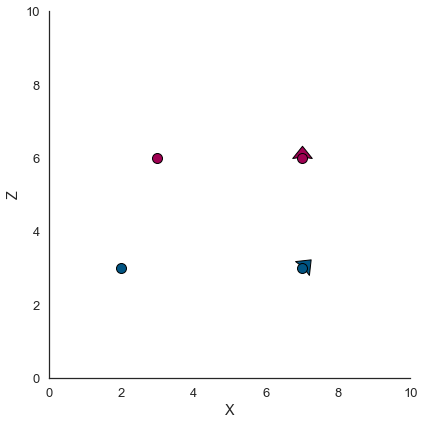

In [22]:
gp._plot.plot_data(geo_model)

In [23]:
# Create the theano model
gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                         values
range            14.2828568571
$C_o$             4.8571428571
drift equations         [3, 3]


In [24]:
# Compute the model
sol = gp.compute_model(geo_model, compute_mesh=False)

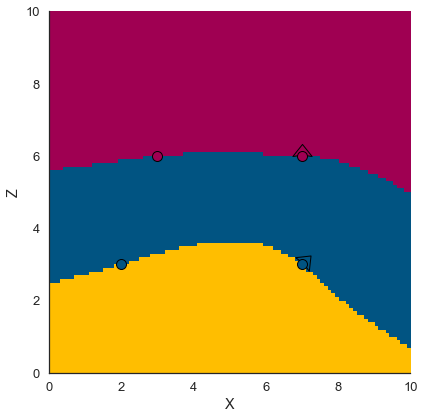

In [25]:
gp._plot.plot_section(geo_model, cell_number=2, direction='y', show_data=True)

Adding a second _Orientation_ value changes the model drastically compared to the previous one. The two different orienation values create a gradient-field which curves the layers although the interface points are at the same depth. In addition, the blue unit is curved more than the red one, as the flat orientation value at Z=6 flattens the gradient field. At Z=3, the blue orientation value causes the more inclined gradient field:

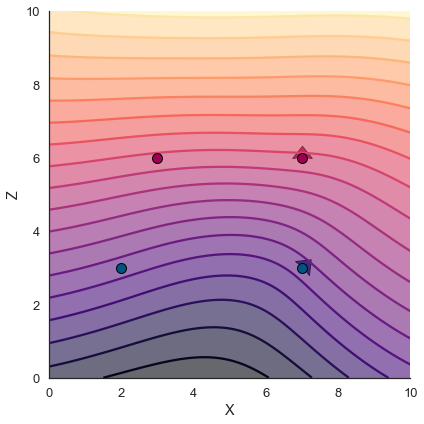

In [26]:
# Darstellen des Gradientenfeldes
gp._plot.plot_scalar_field(geo_model, cell_number=2, direction='y', show_data=True)

<a id='4'></a>
## Fault relations 
Until now, we only looked at continuous rock units. Now we introduce another common feature of geological models: Faults. Faults are discontinuities, which displace rock units. Interfaces and Orientations can be sampled from a fault similarly to a rock unit

Therefore, faults are also modeled similar to geological units in GemPy. They have their own gradient-field, which disturbs the gradient field of geological units. This disturbance causes the displacement of the model surfaces, as those **always** are equal to an iso-line of the gradient-field belonging to the geological unit.

In [27]:
# Modell with 2 faults
geo_model = gp.create_model('2layers_2faults')

gp.init_data(geo_model, [0., 10., 0., 2., 0., 10.], [100, 3, 100],
            path_i = 'data/04_2Layers_2Faults_interfaces.csv',
            path_o = 'data/04_2Layers_2Faults_orientations.csv');

Active grids: ['regular']


In [28]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,unit_1,Default series,1,#015482,1
1,unit_2,Default series,2,#9f0052,2
2,fault1,Default series,3,#ffbe00,3
3,fault2,Default series,4,#728f02,4
4,basement,Basement,1,#443988,5


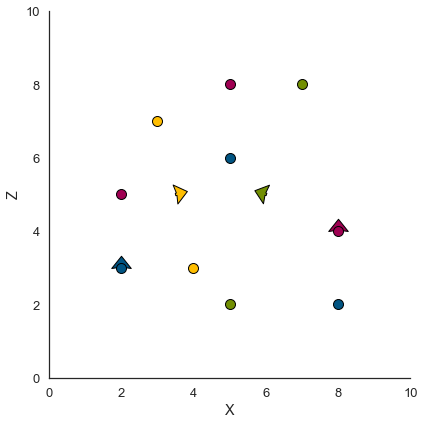

In [29]:
gp._plot.plot_data(geo_model)

A peculiar thing with faults in Gempy is that they should always have their own Series.

The youngest fault-series is at the top, as is the youngest geological unit in a pile. Generally, in a pile, first come the fault series, then the geological series with the relative position **young** --> **old**.

In [30]:
# Add faults to series
gp.map_series_to_surfaces(geo_model,
                         {"Fault2_series":'fault2',
                          "Fault1_series":'fault1',
                          "Strati_series":('unit_2', 'unit_1')})

,surface,series,order_surfaces,color,id
3,fault2,Fault2_series,1,#728f02,1
2,fault1,Fault1_series,1,#ffbe00,2
0,unit_1,Strati_series,1,#015482,3
1,unit_2,Strati_series,2,#9f0052,4
4,basement,Basement,1,#443988,5


Faults have to be set as faults for gempy (so that their gradient field disturbs the others), and can be assigned the same color:

In [31]:
# Störungsfarbe
geo_model.set_is_fault(['Fault1_series', 'Fault2_series'], change_color=True)

Fault colors changed. If you do not like this behavior, set change_color to False.


,order_series,BottomRelation,isActive,isFault,isFinite
Fault2_series,1,Fault,True,True,False
Fault1_series,2,Fault,True,True,False
Strati_series,3,Erosion,True,False,False
Basement,4,Erosion,False,False,False


In [32]:
# Create the theano model
gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                         values
range            14.2828568571
$C_o$             4.8571428571
drift equations   [3, 3, 3, 3]


In [33]:
# Compute the model
sol = gp.compute_model(geo_model)

Plot the result:

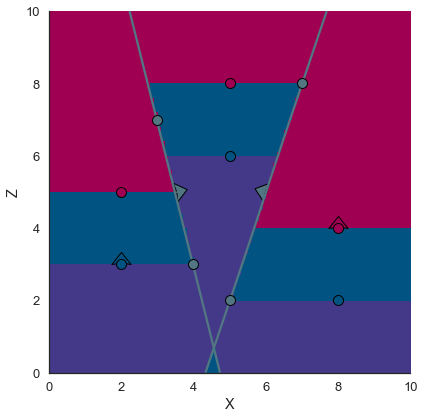

In [34]:
gp._plot.plot_section(geo_model, cell_number=2, direction='y')

In this structure, we see the displacement of blue and purple units along the faults. At the lower model boundary, where the faults cross, we see that the blue unit seems to re-appear. This isn't realistic, probably one fault stops at the other one?

If a fault stops at another one, and also which faults affect which geological units can be defined in a boolean matrix, the `fault_relations_df`:

In [35]:
# fault relations dataframe
geo_model.faults.faults_relations_df

,Fault2_series,Fault1_series,Strati_series,Basement
Fault2_series,False,False,True,True
Fault1_series,False,False,True,True
Strati_series,False,False,False,False
Basement,False,False,False,False


This fault relation boolean matrix shows True if a fault displaces another series (regardless if it is a geological unit or another fault). Default is: all faults displace all geological units. If we would like to let `Fault1` be affected by `Fault2`, we set the respective entry to `True`.
The `fault_relations_df` is an "upper triangular matrix", so we only look at the upper right half.

In [36]:
# New Boolean Array
fr = np.array([[False, True, True, True],
               [False, False, True, True],
               [False, False, False, False],
               [False, False, False, False]])

In [37]:
geo_model._faults.set_fault_relation(fr)

,Fault2_series,Fault1_series,Strati_series,Basement
Fault2_series,False,True,True,True
Fault1_series,False,False,True,True
Strati_series,False,False,False,False
Basement,False,False,False,False


In [38]:
# Create the theano model
gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  2
Compilation Done!
Kriging values: 
                         values
range            14.2828568571
$C_o$             4.8571428571
drift equations   [3, 3, 3, 3]


In [39]:
# Compute the model
sol = gp.compute_model(geo_model, compute_mesh=False)

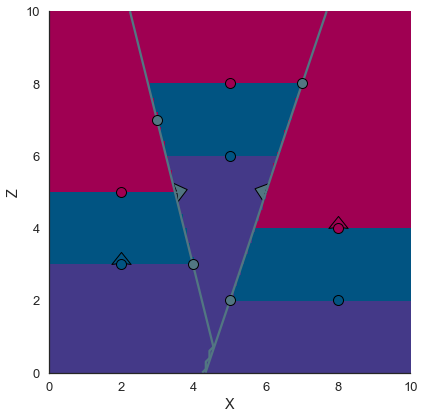

In [41]:
# Show the faults
gp._plot.plot_section(geo_model, cell_number=1, direction='y', show_data=True)

Here we see that `Fault1` stopps at the other fault, and follows now `Fault2`. Faults are visible throughout the model space, but don't affect the whole model domain!

<a id='5'></a>
## Onlap Relations

Series in GemPy can have two different _Relations_ compared to older, underlying Series. The two _Relations_ are `Onlap` or `Erode`. Per default all younger units erode older units, so their bottom_relation is `Erode`. If this is changed to `Onlap`, a younger Unit stops at an older one.

Let's test this in a model:

In [42]:
# Model creation
geo_model = gp.create_model('Test_model')

In [43]:
gp.init_data(geo_model, [0, 10., 0, 2., 0, 5.], [100, 3, 100],
            path_o = 'data/05_toy_fold_unconformity_orientations.csv',
             path_i = 'data/05_toy_fold_unconformity_interfaces.csv', default_values=True);

Active grids: ['regular']


In [44]:
geo_model.surfaces

,surface,series,order_surfaces,color,id
0,Basefold,Default series,1,#015482,1
1,Topfold,Default series,2,#9f0052,2
2,Inclined,Default series,3,#ffbe00,3
3,Flat,Default series,4,#728f02,4
4,basement,Basement,1,#443988,5


In [45]:
# Map the units to series
gp.map_series_to_surfaces(geo_model,
                         {"Flat_Series":'Flat',
                          "Inclined_Series":'Inclined',
                          "Fold_Series": ('Basefold', 'Topfold')})

,surface,series,order_surfaces,color,id
3,Flat,Flat_Series,1,#728f02,1
2,Inclined,Inclined_Series,1,#ffbe00,2
0,Basefold,Fold_Series,1,#015482,3
1,Topfold,Fold_Series,2,#9f0052,4
4,basement,Basement,1,#443988,5


Now, all units have their own Series. A "folded" one in the lower left corner, a single "inclined" Series and a flat one, the youngest:

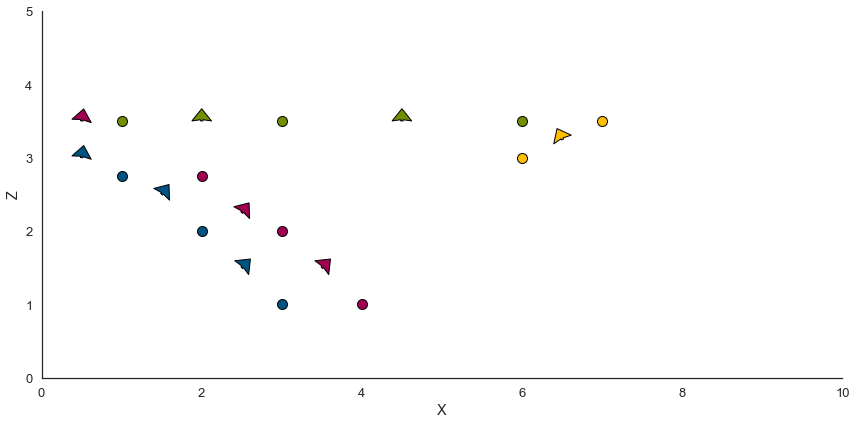

In [46]:
gp._plot.plot_data(geo_model, direction='y')

<div class="alert alert-info"> 
    
**Question:** 
All Units have `BottomRelation` `Erode` gesetzt. How do you think the resulting model will look like?
</div>

In [47]:
geo_model.series

,order_series,BottomRelation,isActive,isFault,isFinite
Flat_Series,1,Erosion,True,False,False
Inclined_Series,2,Erosion,True,False,False
Fold_Series,3,Erosion,True,False,False
Basement,4,Erosion,False,False,False


In [48]:
# Create the theano model
gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[])

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                         values
range            11.3578166916
$C_o$             3.0714285714
drift equations   [3, 3, 3, 3]


In [49]:
# Compute the model
sol = gp.compute_model(geo_model, compute_mesh=False)

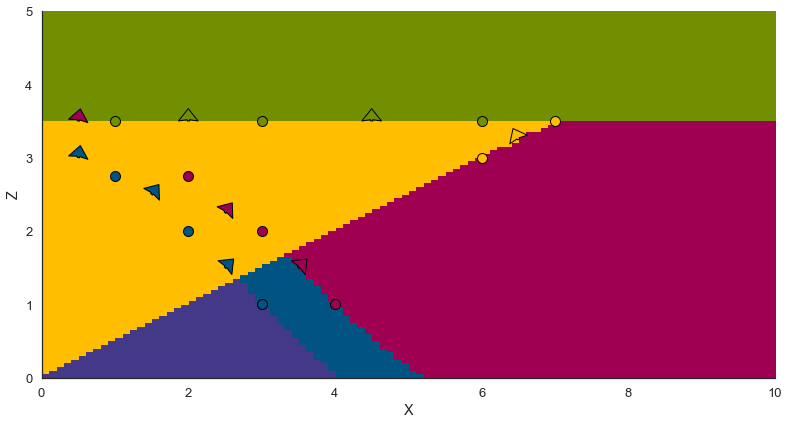

In [50]:
gp._plot.plot_section(geo_model, cell_number=2, direction='y')

As expected?

<a id='5.1'></a>
### Inclined as ONLAP

Now let's have a look what happens if `Inclined` is set to `BottomRelation` Onlap.

In [51]:
# Inclined to Onlap
geo_model._series.set_bottom_relation('Inclined_Series', bottom_relation='Onlap')

,order_series,BottomRelation,isActive,isFault,isFinite
Flat_Series,1,Erosion,True,False,False
Inclined_Series,2,Onlap,True,False,False
Fold_Series,3,Erosion,True,False,False
Basement,4,Erosion,False,False,False


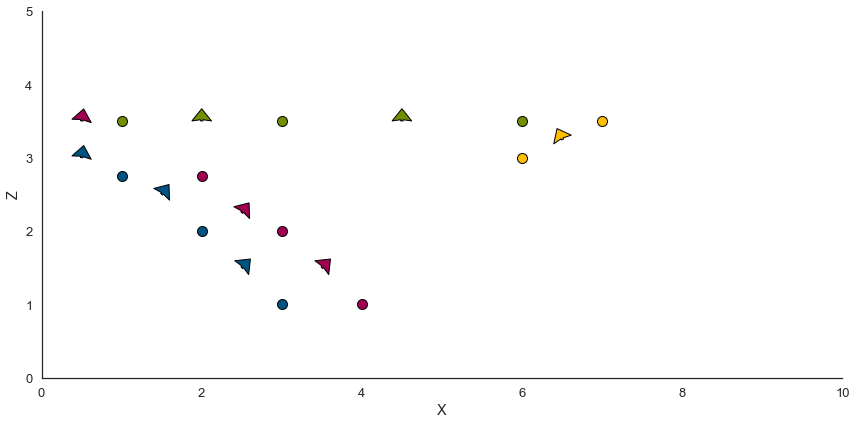

In [52]:
# Data Plot
gp._plot.plot_data(geo_model, direction='y')

In [53]:
# Create the theano model
gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[])
# Compute the model
sol = gp.compute_model(geo_model, compute_mesh=False)

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                         values
range            11.3578166916
$C_o$             3.0714285714
drift equations   [3, 3, 3, 3]


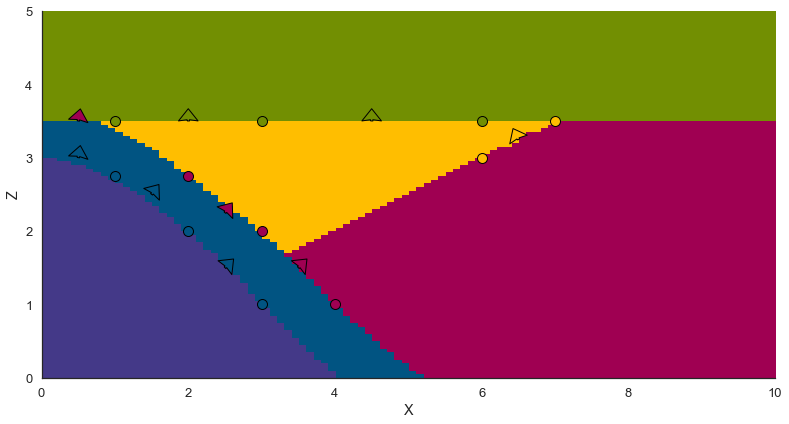

In [54]:
# result Plot
gp._plot.plot_section(geo_model, cell_number=2, direction='y')

This might be somewhat confusing? But when we look closely, this actually makes Sense!

<a id='5.2'></a>
### Inclined and Flat as ONLAP

Now next to `Inclined` we also set the Series `Flat` on _Onlap_, and have a look at the result:

In [55]:
# both young series are now onlap:
geo_model._series.set_bottom_relation(['Flat_Series','Inclined_Series'], bottom_relation='Onlap')

,order_series,BottomRelation,isActive,isFault,isFinite
Flat_Series,1,Onlap,True,False,False
Inclined_Series,2,Onlap,True,False,False
Fold_Series,3,Erosion,True,False,False
Basement,4,Erosion,False,False,False


In [56]:
# Create the theano model
gp.set_interpolator(geo_model,
                         compile_theano=True,
                         theano_optimizer='fast_compile',
                         verbose=[])
# Compute the model
sol = gp.compute_model(geo_model, compute_mesh=False)

Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                         values
range            11.3578166916
$C_o$             3.0714285714
drift equations   [3, 3, 3, 3]


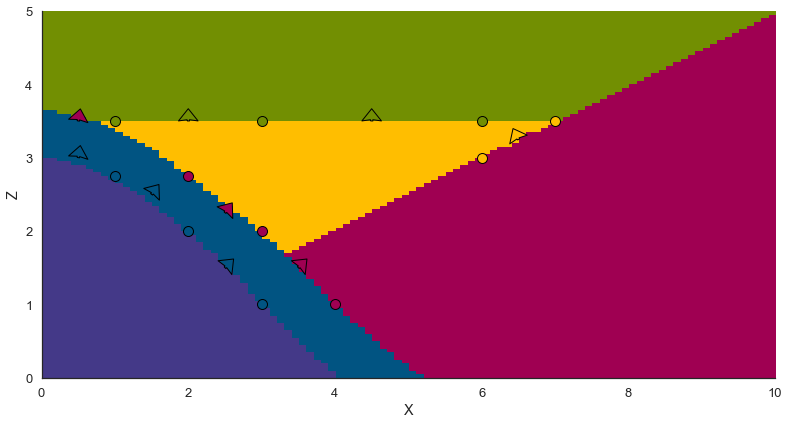

In [57]:
# result plot
gp._plot.plot_section(geo_model, cell_number=2, direction='y')

Let's have a look at the model in 3D

In [58]:
gp.plot_3d(geo_model, plotter_type='background')

<a id='6'></a>
## Final thoughts

In this notebook, we tried to give an overview over the most basic GemPy functionalities, Surfaces, Series, Relations...all that builds the basis of GemPy, but its functionality goes way beyond that. However, it is important to understand the basics shown here, as they help to build more complex models (with a robust fundament).

In [ ]:
print("That's all folks!")